In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

nltk.download('punkt')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import re
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import adam_v2

import os

print("Imports complete!!!")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/justusgriego/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justusgriego/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Imports complete!!!


In [2]:
dataset = pd.read_csv('play_by_play_2021.csv')
print(dataset.shape)
print(dataset.head(3))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(50536, 372)
   play_id          game_id  old_game_id home_team away_team season_type  \
0        1  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
1       40  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
2       55  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   

   week posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0     1     NaN          NaN     NaN  ...             0                     1   
1     1     TEN         home     ARI  ...             0                     1   
2     1     TEN         home     ARI  ...             0                     1   

     qb_epa  xyac_epa  xyac_mean_yardage  xyac_median_yardage xyac_success  \
0       NaN       NaN                NaN                  NaN          NaN   
1  0.000000       NaN                NaN                  NaN          NaN   
2 -1.399805       NaN                NaN                  NaN          NaN   

   xyac_fd     xpass    pass_oe  
0      NaN

In [3]:
all_titles = ["play_id","game_id","old_game_id","home_team","away_team","season_type","week","posteam","posteam_type","defteam","side_of_field","yardline_100","game_date","quarter_seconds_remaining","half_seconds_remaining","game_seconds_remaining","game_half","quarter_end","drive","sp","qtr","down","goal_to_go","time","yrdln","ydstogo","ydsnet","desc","play_type","yards_gained","shotgun","no_huddle","qb_dropback","qb_kneel","qb_spike","qb_scramble","pass_length","pass_location","air_yards","yards_after_catch","run_location","run_gap","field_goal_result","kick_distance","extra_point_result","two_point_conv_result","home_timeouts_remaining","away_timeouts_remaining","timeout","timeout_team","td_team","td_player_name","td_player_id","posteam_timeouts_remaining","defteam_timeouts_remaining","total_home_score","total_away_score","posteam_score","defteam_score","score_differential","posteam_score_post","defteam_score_post","score_differential_post","no_score_prob","opp_fg_prob","opp_safety_prob","opp_td_prob","fg_prob","safety_prob","td_prob","extra_point_prob","two_point_conversion_prob","ep","epa","total_home_epa","total_away_epa","total_home_rush_epa","total_away_rush_epa","total_home_pass_epa","total_away_pass_epa","air_epa","yac_epa","comp_air_epa","comp_yac_epa","total_home_comp_air_epa","total_away_comp_air_epa","total_home_comp_yac_epa","total_away_comp_yac_epa","total_home_raw_air_epa","total_away_raw_air_epa","total_home_raw_yac_epa","total_away_raw_yac_epa","wp","def_wp","home_wp","away_wp","wpa","vegas_wpa","vegas_home_wpa","home_wp_post","away_wp_post","vegas_wp","vegas_home_wp","total_home_rush_wpa","total_away_rush_wpa","total_home_pass_wpa","total_away_pass_wpa","air_wpa","yac_wpa","comp_air_wpa","comp_yac_wpa","total_home_comp_air_wpa","total_away_comp_air_wpa","total_home_comp_yac_wpa","total_away_comp_yac_wpa","total_home_raw_air_wpa","total_away_raw_air_wpa","total_home_raw_yac_wpa","total_away_raw_yac_wpa","punt_blocked","first_down_rush","first_down_pass","first_down_penalty","third_down_converted","third_down_failed","fourth_down_converted","fourth_down_failed","incomplete_pass","touchback","interception","punt_inside_twenty","punt_in_endzone","punt_out_of_bounds","punt_downed","punt_fair_catch","kickoff_inside_twenty","kickoff_in_endzone","kickoff_out_of_bounds","kickoff_downed","kickoff_fair_catch","fumble_forced","fumble_not_forced","fumble_out_of_bounds","solo_tackle","safety","penalty","tackled_for_loss","fumble_lost","own_kickoff_recovery","own_kickoff_recovery_td","qb_hit","rush_attempt","pass_attempt","sack","touchdown","pass_touchdown","rush_touchdown","return_touchdown","extra_point_attempt","two_point_attempt","field_goal_attempt","kickoff_attempt","punt_attempt","fumble","complete_pass","assist_tackle","lateral_reception","lateral_rush","lateral_return","lateral_recovery","passer_player_id","passer_player_name","passing_yards","receiver_player_id","receiver_player_name","receiving_yards","rusher_player_id","rusher_player_name","rushing_yards","lateral_receiver_player_id","lateral_receiver_player_name","lateral_receiving_yards","lateral_rusher_player_id","lateral_rusher_player_name","lateral_rushing_yards","lateral_sack_player_id","lateral_sack_player_name","interception_player_id","interception_player_name","lateral_interception_player_id","lateral_interception_player_name","punt_returner_player_id","punt_returner_player_name","lateral_punt_returner_player_id","lateral_punt_returner_player_name","kickoff_returner_player_name","kickoff_returner_player_id","lateral_kickoff_returner_player_id","lateral_kickoff_returner_player_name","punter_player_id","punter_player_name","kicker_player_name","kicker_player_id","own_kickoff_recovery_player_id","own_kickoff_recovery_player_name","blocked_player_id","blocked_player_name","tackle_for_loss_1_player_id","tackle_for_loss_1_player_name","tackle_for_loss_2_player_id","tackle_for_loss_2_player_name","qb_hit_1_player_id","qb_hit_1_player_name","qb_hit_2_player_id","qb_hit_2_player_name","forced_fumble_player_1_team","forced_fumble_player_1_player_id","forced_fumble_player_1_player_name","forced_fumble_player_2_team","forced_fumble_player_2_player_id","forced_fumble_player_2_player_name","solo_tackle_1_team","solo_tackle_2_team","solo_tackle_1_player_id","solo_tackle_2_player_id","solo_tackle_1_player_name","solo_tackle_2_player_name","assist_tackle_1_player_id","assist_tackle_1_player_name","assist_tackle_1_team","assist_tackle_2_player_id","assist_tackle_2_player_name","assist_tackle_2_team","assist_tackle_3_player_id","assist_tackle_3_player_name","assist_tackle_3_team","assist_tackle_4_player_id","assist_tackle_4_player_name","assist_tackle_4_team","tackle_with_assist","tackle_with_assist_1_player_id","tackle_with_assist_1_player_name","tackle_with_assist_1_team","tackle_with_assist_2_player_id","tackle_with_assist_2_player_name","tackle_with_assist_2_team","pass_defense_1_player_id","pass_defense_1_player_name","pass_defense_2_player_id","pass_defense_2_player_name","fumbled_1_team","fumbled_1_player_id","fumbled_1_player_name","fumbled_2_player_id","fumbled_2_player_name","fumbled_2_team","fumble_recovery_1_team","fumble_recovery_1_yards","fumble_recovery_1_player_id","fumble_recovery_1_player_name","fumble_recovery_2_team","fumble_recovery_2_yards","fumble_recovery_2_player_id","fumble_recovery_2_player_name","sack_player_id","sack_player_name","half_sack_1_player_id","half_sack_1_player_name","half_sack_2_player_id","half_sack_2_player_name","return_team","return_yards","penalty_team","penalty_player_id","penalty_player_name","penalty_yards","replay_or_challenge","replay_or_challenge_result","penalty_type","defensive_two_point_attempt","defensive_two_point_conv","defensive_extra_point_attempt","defensive_extra_point_conv","safety_player_name","safety_player_id","season","cp","cpoe","series","series_success","series_result","order_sequence","start_time","time_of_day","stadium","weather","nfl_api_id","play_clock","play_deleted","play_type_nfl","special_teams_play","st_play_type","end_clock_time","end_yard_line","fixed_drive","fixed_drive_result","drive_real_start_time","drive_play_count","drive_time_of_possession","drive_first_downs","drive_inside20","drive_ended_with_score","drive_quarter_start","drive_quarter_end","drive_yards_penalized","drive_start_transition","drive_end_transition","drive_game_clock_start","drive_game_clock_end","drive_start_yard_line","drive_end_yard_line","drive_play_id_started","drive_play_id_ended","away_score","home_score","location","result","total","spread_line","total_line","div_game","roof","surface","temp","wind","home_coach","away_coach","stadium_id","game_stadium","aborted_play","success","passer","passer_jersey_number","rusher","rusher_jersey_number","receiver","receiver_jersey_number","pass","rush","first_down","special","play","passer_id","rusher_id","receiver_id","name","jersey_number","id","fantasy_player_name","fantasy_player_id","fantasy","fantasy_id","out_of_bounds","home_opening_kickoff","qb_epa","xyac_epa","xyac_mean_yardage","xyac_median_yardage","xyac_success","xyac_fd","xpass","pass_oe"]
important_titles = ["play_id",
                    "game_id", #Unique Game Id
                    "posteam", #Offence/Possetion Team
                    "result",
                    "posteam_type", #Offence Home/Away
                    "defteam", #Defence Team
                    "yardline_100", #Yards from Touchdown
                    "half_seconds_remaining",
                    "game_half",
                    "drive", #Number of Posetions
                    "down",
                    "goal_to_go", #is it 4th and goal? 0 if no, 1 if yes
                    "time",
                    "ydstogo", #yards till first down/touchdown
                    "desc", #description
                    "play_type",
                    "yards_gained", #0 if punted or field goal
                    "qb_kneel", #rare 4th down occurance but possible
                    "field_goal_result",
                    "kick_distance",
                    "posteam_timeouts_remaining",
                    "defteam_timeouts_remaining",
                    "total_home_score",
                    "total_away_score",
                    "posteam_score",
                    "defteam_score",
                    "score_differential",
                    "score_differential_post", #score differential after play happened
                    "no_score_prob",
                    "opp_fg_prob",
                    "opp_safety_prob",
                    "opp_td_prob",
                    "fg_prob",
                    "safety_prob",
                    "td_prob",
                    "wp", #winning percentage
                    "def_wp", 
                    "home_wp_post",
                    "away_wp_post",
                    "punt_blocked",
                    "third_down_converted",
                    "third_down_failed",
                    "fourth_down_converted",
                    "fourth_down_failed",
                    "punt_inside_twenty",
                    "punt_in_endzone",
                    "punt_out_of_bounds",
                    "punt_downed",
                    "punt_fair_catch",
                    "season", #2021 for now
                    "series_result",
                    "weather",
                    "nfl_api_id", #new data set-ish
                    "play_type_nfl",
                    "special_teams_play", #0 or 1
                    "drive_play_count",
                    "drive_time_of_possession",
                    "drive_first_downs",
                    "drive_inside20",
                    "drive_ended_with_score",
                    "roof",
                    "surface",
                    "wind" #no valuable info could add from weather
                   ]

dataset = dataset[important_titles]

                    
game_winners = {}
for x in dataset['game_id'].unique():
    temp = dataset.copy()
    temp = temp[(temp['game_id'] == x) & (temp['desc'] == "END GAME")]
    if (temp['total_home_score'] > temp["total_away_score"]).bool():
        game_winners[x] = "home"
    elif (temp['total_home_score'] < temp["total_away_score"]).bool():
        game_winners[x] = "away"
    else:
        game_winners[x] = "TIE"
    
                    
def f(row):
    game_id = row['game_id']
    winner = game_winners[game_id]
    if row['posteam_type'] == winner:
        return 1
    else:
        return 0

dataset['Won'] = dataset.apply(f, axis=1) #TIE CONSIDERED 0

In [4]:
fourthdown = dataset[dataset['down']==4]
print(fourthdown.shape)

(4235, 64)


(4235,)


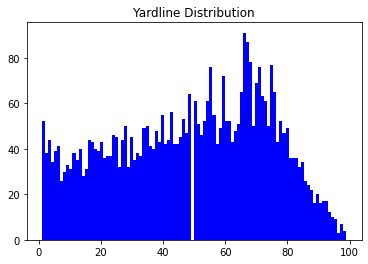

In [5]:
yardline = fourthdown['yardline_100']
print(yardline.shape)

plt.hist(yardline,color='blue', bins = 100)
plt.title('Yardline Distribution')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Play Types')]

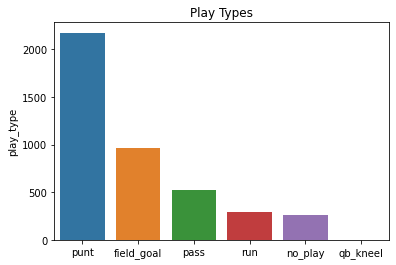

In [6]:
x = fourthdown.play_type.value_counts()
sns.barplot(x.index, x,).set(title="Play Types")



In [7]:
# result feature gives final score 
# negative score in favor of away team, positive score in favor of home team
# how do we classify a tie?

# won = fourthdown[(fourthdown['posteam_type'] == 'home' & fourthdown['result'] > 0) | (fourthdown['posteam_type'] == 'away' & fourthdown['result'] < 0)]
def who_won(row):
    row = row.to_numpy()
    if((row[0] == 'home' and row[1] > 0) or (row[0] == 'away' and row[1] < 0)):
        return 1
    return 0

labels = fourthdown[['posteam_type', 'result']].apply(who_won, axis=1)
fourthdown['labels'] = labels
print(fourthdown['labels'])

5        0
16       1
31       0
35       1
39       0
        ..
50497    0
50498    0
50507    1
50513    0
50526    1
Name: labels, Length: 4235, dtype: int64


/var/folders/bw/lg50kkvx081f41_6vrd9w_kh0000gn/T/ipykernel_20888/559978046.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['labels'] = labels


In [8]:
won = fourthdown[fourthdown['labels'] == 1]
lost = fourthdown[fourthdown['labels'] == 0]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Label Counts')]

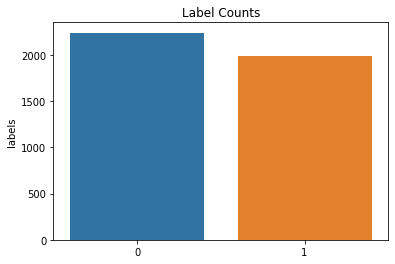

In [9]:
x = fourthdown.labels.value_counts()
sns.barplot(x.index, x,).set(title="Label Counts")

(-1.10976323089917,
 1.1004649199936059,
 -1.1141850335783672,
 1.1086906809927233)

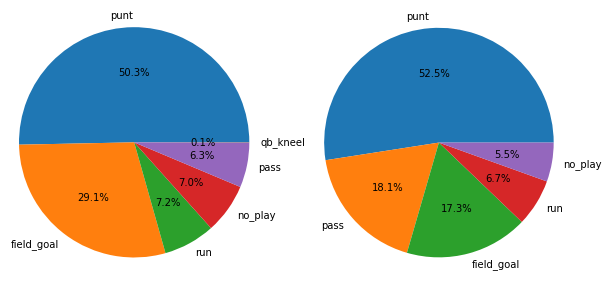

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

a = won.play_type.value_counts()
b = lost.play_type.value_counts()


ax1.pie(a,  labels=a.index,autopct='%1.1f%%')
ax1.axis('equal')

ax2.pie(b,  labels=b.index,autopct='%1.1f%%')
ax2.axis('equal')



This is the spread of plays that will be classified as successful or not successful in our dataset. This is interesting (notably difference in field goal and pass), but needs more context. 

# Problem Space 1 - Weighing Samples' relevance to the final outcome of the game (Lucas)

Idea: Samples that are most relevant are ones where the outcome of the game is not yet determined - 50/50 probability of winning

Idea: Samples that are most relevant are ones which create the biggest swing in win probability

# Problem Space 2 - Feature Engineering: Go through dataset and get keep all features which could potentially be useful. Also do some analysis on the features.

# Problem Space 3 - Train a Baseline Model and try to find ways to improve it